In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

plt.rc('figure', figsize=(10, 7))

In [2]:
tf.__version__

'1.1.0-rc2'

## Loading data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [5]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

## Data dimensions

In [6]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = [img_size, img_size]
num_classes = 10

## Helper functions

In [7]:
# helper function to plot images
def plot_images(images, cls_true, cls_pred=None):
    img_cnt = len(images)

    # some sanity checks on inputs
    assert img_cnt == len(cls_true)
    if cls_pred is not None:
        assert img_cnt == len(cls_pred)

    # compute plot size. Do not plot more than 100 images
    plt_size = int(np.ceil(np.sqrt(img_cnt)))
    assert plt_size <= 10
    
    fig, axes = plt.subplots(plt_size, plt_size)
    
    # adjust spacing
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    empty_image = np.zeros(img_shape)

    for i, ax in enumerate(axes.flat):
        if i < img_cnt:
            ax.imshow(images[i].reshape(img_shape), cmap='binary')

            if cls_pred is not None:
                xlabel = 'True: {0}, Pred: {1}'.format(cls_true[i], cls_pred[i])
            else:
                xlabel = 'True: {0}'.format(cls_true[i])
        
            ax.set_xlabel(xlabel)
        else:
            ax.imshow(empty_image, cmap='binary')

        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

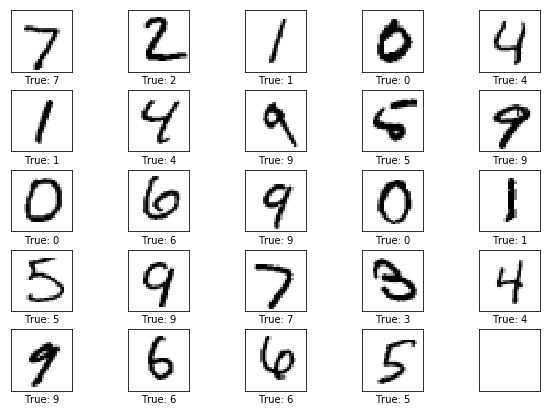

In [8]:
plot_images(data.test.images[0:24], data.test.cls[0:24])

# TensorFlow Graph

## Placeholder variables

In [9]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

## Weights & biases

In [10]:
weights = tf.Variable(tf.truncated_normal([img_size_flat, num_classes], mean=0.0, stddev=0.01))
biases = tf.Variable(tf.truncated_normal([num_classes], mean=0.0, stddev=0.01))

## Model

In [11]:
logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

## Cost function

In [12]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

## Opitmization method

In [13]:
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## Performance measures

In [14]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [16]:
from show_tf_graph import show_graph
show_graph(tf.get_default_graph().as_graph_def())

# TensorFlow Run

## Create a session

In [17]:
session = tf.Session()
session.run(tf.global_variables_initializer())

## Helper function to perform optimization iterations

In [18]:
batch_size = 128
def optimize(iterations):
    for i in range(iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        feed_dict = {x: x_batch, y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict)

## Helper functions to show performance

In [19]:
feed_dict_test = {x: data.test.images, y_true: data.test.labels, y_true_cls: data.test.cls}

def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print('Accuracy on the test set: {0:.1%}'.format(acc))

def plot_confusion_matrix():
    cls_true = data.test.cls
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)

    # plot the matrix as an image
    plt.matshow(cm)
    
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

def plot_example_errors(num_errors=16):
    correct, cls_pred = session.run([correct_prediction, y_pred_cls], feed_dict=feed_dict_test)
    
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    
    plot_images(images=images[0:num_errors],
                cls_true=cls_true[0:num_errors],
                cls_pred=cls_pred[0:num_errors])

## Helper function to plot the model's weights

In [20]:
def plot_weights():
    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        if i < 10:
            image = w[:, i].reshape(img_shape)
            ax.set_xlabel('Weights: {0}'.format(i))
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])

## Performance before any optimization

In [21]:
print_accuracy()

Accuracy on the test set: 13.3%


[[603  82  22  31 140   9  14   7  13  59]
 [ 59   0   0 280 726  10  12   0   1  47]
 [412   7   3 109 395  16   4   4   9  73]
 [119   0  34 491 248   0  28   2   4  84]
 [ 70  27  17 462  99   1  23   7  27 249]
 [ 59  15   4 514 185   5  44  10  16  40]
 [345   2   0 223 146   1  34   7  18 182]
 [180  18  22 303 196   0 133   0  22 154]
 [114   0   1 257 572   0   5  11   4  10]
 [182   6   3 339 226   0 130   1  26  96]]


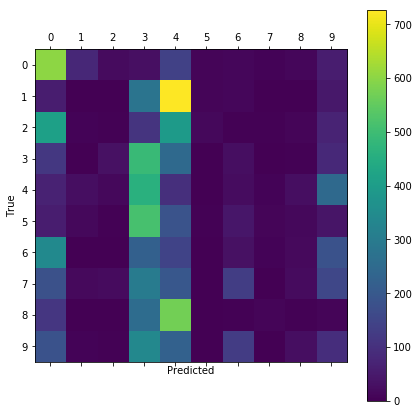

In [22]:
plot_confusion_matrix()

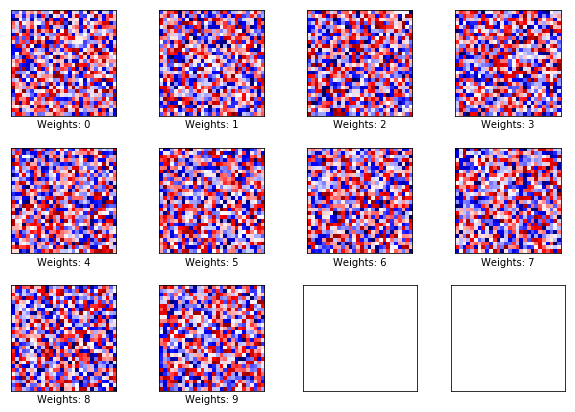

In [23]:
plot_weights()

## Performance after one iteration

In [24]:
optimize(iterations=1)

In [25]:
print_accuracy()

Accuracy on the test set: 14.6%


[[645  62  21  39 120  12  14   6   9  52]
 [ 59   0   0 294 712  12  12   0   1  45]
 [432   5   3 119 370  15   7   4   7  70]
 [114   0  27 545 212   0  27   2   4  79]
 [ 69  23  12 463  96   1  24   7  24 263]
 [ 58  12   2 550 161   6  40   9  15  39]
 [345   1   0 233 138   1  40   7  14 179]
 [173  14  18 318 186   0 120   0  20 179]
 [115   0   1 285 543   0   6  11   3  10]
 [164   5   1 348 219   0 124   1  21 126]]


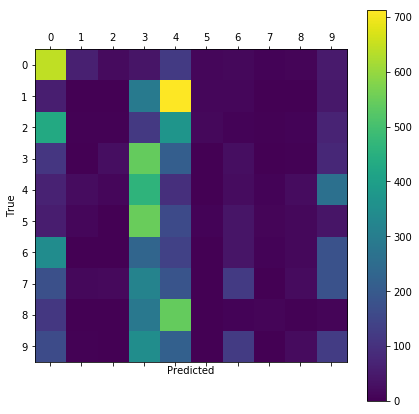

In [26]:
plot_confusion_matrix()

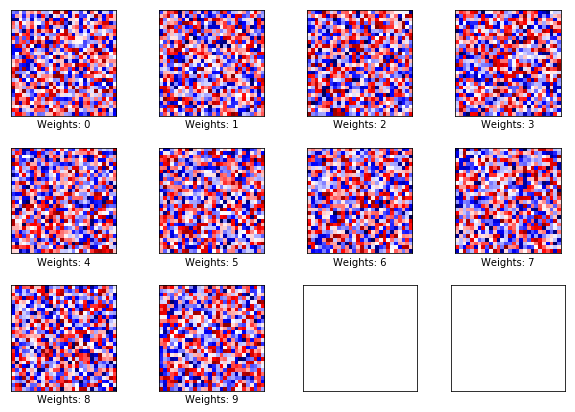

In [27]:
plot_weights()

## Performance after 10 iterations

In [28]:
optimize(iterations=9)

In [29]:
print_accuracy()

Accuracy on the test set: 22.6%


[[825   6  12  30  49   6  12   1  13  26]
 [ 73   0   0 317 628   8  11   0   1  97]
 [453   1  19 144 306   4  17   2  25  61]
 [ 94   0  14 715 100   0  14   0  13  60]
 [ 78   1   3 286 145   0  26   2  30 411]
 [ 86   2   2 564 112   7  29   3  45  42]
 [334   0   0 155 113   1 136   2  34 183]
 [139   3   5 197 167   0  39   1  19 458]
 [133   0   1 312 477   0   4   6  23  18]
 [ 75   1   1 213 256   0  59   1  18 385]]


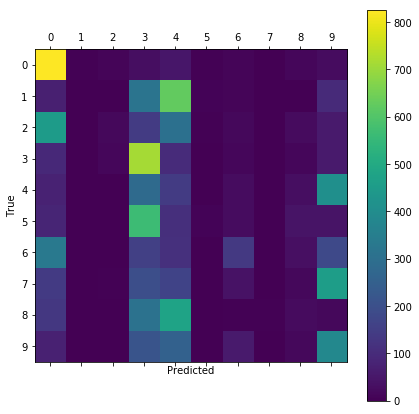

In [30]:
plot_confusion_matrix()

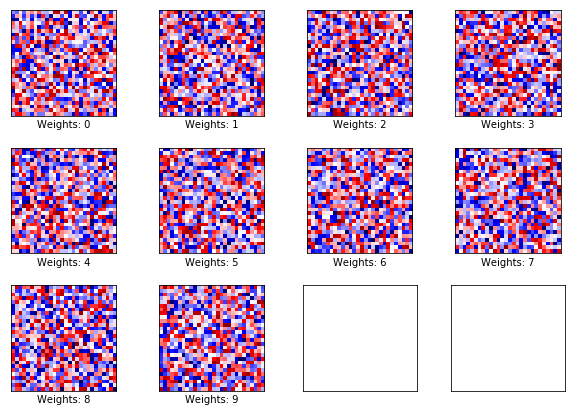

In [31]:
plot_weights()

## Performance after 1000 iterations

In [32]:
optimize(iterations=990)

In [33]:
print_accuracy()

Accuracy on the test set: 85.4%


[[ 921    0    7    7    0    4   27    1   13    0]
 [   0 1060    7    9    1    1    6    1   50    0]
 [  21   23  850   27   17    0   24   19   47    4]
 [   5    9   29  884    2   19    8   17   25   12]
 [   2    9    4    0  836    0   23    2   10   96]
 [  18   14    5  116   23  595   24    9   66   22]
 [  24   18    9    0   11   15  877    0    4    0]
 [   2   36   22    3   12    0    3  878   15   57]
 [  15   29   10   58   12   17   11   17  785   20]
 [  16   14    9   12   43    6    1   43   14  851]]


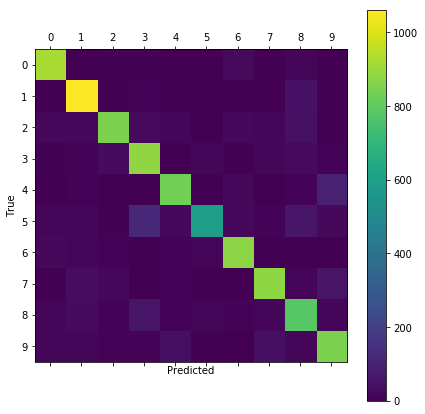

In [34]:
plot_confusion_matrix()

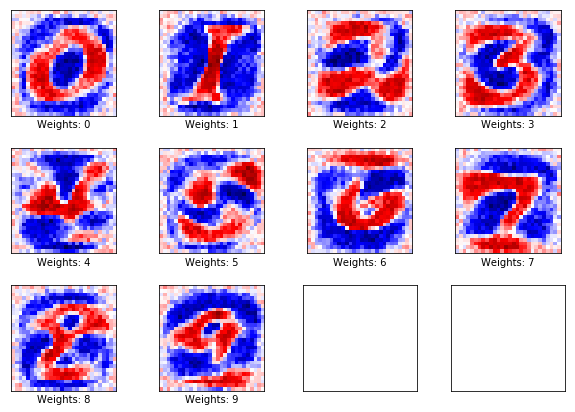

In [35]:
plot_weights()

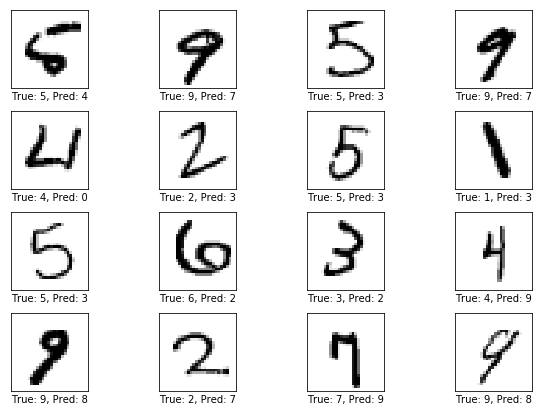

In [36]:
plot_example_errors()

## Performance after 20000 iterations

In [37]:
optimize(iterations=19000)

In [38]:
print_accuracy()

Accuracy on the test set: 92.3%


[[ 962    0    1    1    0    5    7    3    1    0]
 [   0 1114    2    2    0    2    4    2    9    0]
 [   8   11  917   18   11    3   12   10   37    5]
 [   3    0   22  913    0   26    3   11   22   10]
 [   1    1    3    1  918    0   13    2    9   34]
 [  10    2    3   32    9  770   17    7   34    8]
 [  14    3    6    1    8   11  912    2    1    0]
 [   1    7   23    8    7    0    0  943    2   37]
 [   8    7    7   21    9   27   11   11  862   11]
 [  11    7    1   11   30    8    0   19    6  916]]


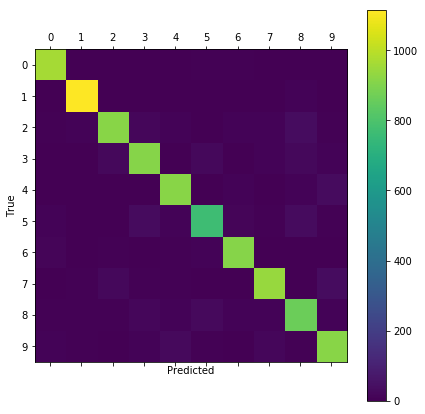

In [39]:
plot_confusion_matrix()

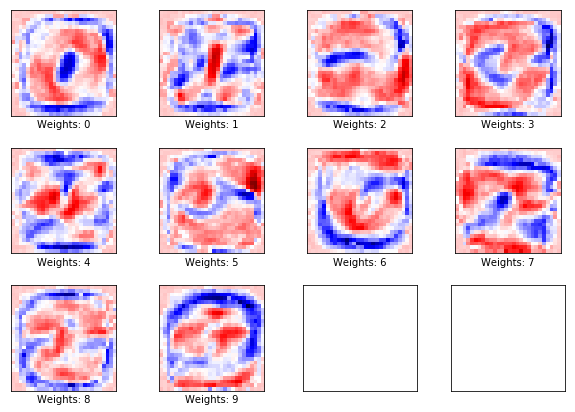

In [40]:
plot_weights()

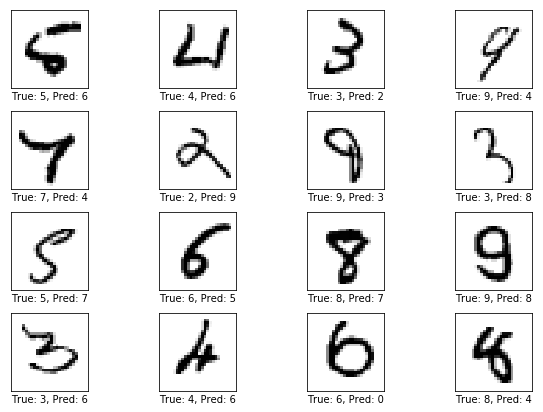

In [41]:
plot_example_errors()

In [42]:
# close TensorFlow Session
session.close()